# Analysis of Developer Experience and Code Quality Metrics

This Jupyter notebook performs an analysis of the relationship between developer experience and code quality metrics.

The analysis includes:
- Processing of developer profiles from Workana to extract experience levels
- Processing of code quality metrics extracted from GitHub repositories
- Statistical tests and visualizations

The notebook uses Python libraries like pandas for data manipulation, matplotlib/seaborn for visualization, and scipy for statistical analysis.

## Initialization

In [98]:
%pip install pandas matplotlib seaborn scipy openpyxl
%pip install numpy==1.26.4
%pip install scikit-learn
%pip install pysubgroup

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [99]:
import pandas as pd
import numpy as np
import os
import glob
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

# Configure visualization aesthetics
sns.set(style="whitegrid")
%matplotlib inline

In [100]:
## Path to workana profiles 
profiles_path = 'workana_profiles.csv'

## Path to saved github repositories
repos_path = 'repos_v2/'

In [101]:
import shutil

# Create the destination directory if it doesn't exist
metrics_dataset_folder = 'metrics-dataset'
os.makedirs(metrics_dataset_folder, exist_ok=True)

# Find all .csv files in the repos_path
csv_files = glob.glob(os.path.join(repos_path, '**', '*.xlsx'), recursive=True)

# Copy each .csv file to the destination directory
for file in csv_files:
    # check if file name contains "aggregated" or "condensed"
    if "aggregated" in file or "condensed" in file:
        shutil.copy(file, metrics_dataset_folder)

## Data Load, Transformation and Filtering

In [102]:
workana_profiles = pd.read_csv(profiles_path, sep=';', encoding='utf-8')

In [103]:
## List of programming languages to consider from Workana profiles
## Not possible to analyize: Java, C#, C++, C due to SonarQube limitations
programming_languages = ['JavaScript', 'PHP', 'Python']
# programming_languages = ['JavaScript', 'PHP', 'HTML', 'XML', 'CSS',  'TypeScript', 'Python', 'Ruby (Ruby on Rails)', 'Go/Golang', 'Scala', 'Delphi', 'SQL', 'LUA', 'Powershell']

#### Creating a new column EXPERIENCE in the dataset for each programming language analyized (based on the Workana profile)

In [104]:
NO_XP = "No experience"
UNDER_THREE_YEARS = "<3"
THREE_TO_FIVE_YEARS = "3-5"
MORE_THAN_FIVE_YEARS = ">5"

In [105]:
## Function to extract field of years of experience from Workana profiles.
## It will get the column 'skills' and extract the languages and the years of experience.
## The format will be YOE: 1-3, 4-5, etc.
def extract_experience_ordinal(skill_str):
    """
    Extracts programming languages and their experience in years from the skills string.
    Returns a dictionary with language as key and experience in years as value.
    """
    skills = skill_str.split(', ')
    skill_dict = {}

    def add_lang_experience(lang, years_start, years_end=None):
        # Merging SQL variants into one
        years_start = int(years_start)
        years_end = int(years_end) if years_end else None
        
        if 'sql' in lang.lower():
            lang = 'SQL'
        
        # Merging HTML variants into one
        if 'html' in lang.lower():
            lang = 'HTML'

        if years_start == 1 and years_end == None:
            years = UNDER_THREE_YEARS
        elif years_start == 1 and years_end == 3:
            years = UNDER_THREE_YEARS
        elif years_start == 3 and years_end == 5:
            years = THREE_TO_FIVE_YEARS
        elif years_start == 5 and years_end == 10:
            years = MORE_THAN_FIVE_YEARS
        elif years_start == 10:
            years = MORE_THAN_FIVE_YEARS
        else:
            raise ValueError(f"Unexpected year_start as {years_start} and year_end as {years_end}")

        skill_dict[lang] = years

    for skill in skills:
        # Match pattern with "years", "year", "anos" or "ano"
        match = re.match(r'(.+?)\s*\((\d+)(?:\s*(?:to|a)\s*(\d+)?)?\s*(?:years?|anos?)\)', skill)
        if match:
            lang = match.group(1).strip()
            year_start = int(match.group(2))
            year_end = match.group(3)

            if year_end:
                add_lang_experience(lang, year_start, year_end)
            else:
                add_lang_experience(lang, year_start)
        else:
            # Match pattern with "+" and "years", "year", "anos" or "ano" 
            match = re.match(r'(.+?)\s*\(\+(\d+)\s*(?:years?|anos?)\)', skill)
            if match:
                lang = match.group(1).strip()
                years = int(match.group(2))

                add_lang_experience(lang, years)
            else:
                print(f"No match found for skill: {skill}")
    return skill_dict

In [106]:
# Apply the extraction
# This will create a new column for each programming language with the years of experience (ordinal)
workana_profiles['skills_extracted_ordinal'] = workana_profiles['skills'].apply(extract_experience_ordinal)

for lang in programming_languages:
    workana_profiles[lang+'_exp_ordinal'] = workana_profiles['skills_extracted_ordinal'].apply(lambda x: x.get(lang, NO_XP))

No match found for skill: Publicidade no Google


In [107]:
workana_profiles.head()

,url,github,name,title,location,hourly_rate,skills,description,skills_extracted_ordinal,JavaScript_exp_ordinal,PHP_exp_ordinal,Python_exp_ordinal
0,https://www.workana.com/freelancer/bae8fa5d192...,https://github.com/WilkerFreelancer,Dev 1,Design Digital,Brasil,BRL 65.00,"Adobe After Effects (1 ano), Adobe Premiere (1...","""""""Sobre mim Olá! Meu nome é [REDACTED], ten...","{'Adobe After Effects': '<3', 'Adobe Premiere'...",<3,No experience,No experience
1,https://www.workana.com/freelancer/5fdc788bee1...,https://github.com/Randomizando3,Dev 2,Full Stack Developer,Brasil,BRL 40.00,"JavaScript (3 a 5 anos), PHP (5 a 10 anos), My...","""""""Sobre mim Olá, sou o [REDACTED], Desenvol...","{'JavaScript': '3-5', 'PHP': '>5', 'SQL': '>5'...",3-5,>5,No experience
2,https://www.workana.com/freelancer/afbd2255a91...,https://github.com/joaopa12,Dev 3,"Editor de Imagens,Alteração de Ambiente e efeitos",Brasil,BRL 150.00,"WordPress (1 ano), CSS (1 a 3 anos), SEO (1 a ...","""""""Sobre mim Desenvolvedor Web || Front-End""""""","{'WordPress': '<3', 'CSS': '<3', 'SEO': '<3', ...",No experience,No experience,No experience
3,https://www.workana.com/freelancer/4b2105a01d0...,https://github.com/cleiltonoliveira,Dev 4,Full Stack Developer,Brasil,BRL 30.00,"MySQL (1 a 3 anos), JavaScript (1 a 3 anos), J...","""""""Sobre mim Como profissional eu busco a ca...","{'SQL': '<3', 'JavaScript': '<3', 'Java': '<3'...",<3,No experience,No experience
4,https://www.workana.com/freelancer/7ce986761da...,https://github.com/iredhd,Dev 5,Software Developer,Brasil,BRL 90.00,"JavaScript (5 a 10 anos), CSS (5 a 10 anos), H...","""""""Sobre mim I'm 26 years old. I'm in love ...","{'JavaScript': '>5', 'CSS': '>5', 'HTML': '>5'}",>5,No experience,No experience


### Aggregate SonarQube metrics per programming language

In [108]:
# Mapping file extensions to programming languages
extension_to_language = {
    'js': 'JavaScript',
    'ts': 'TypeScript',
    'py': 'Python',
    'php': 'PHP',
    'sql': 'SQL',
    'html': 'HTML',
    'css': 'CSS',
    'rb': 'Ruby',
    'go': 'Go/Golang',
    'rs': 'Rust',
    'lua': 'Lua',
    'ps1': 'Powershell',
}

# Get all condensed_report.xlsx files
report_files = glob.glob(os.path.join(metrics_dataset_folder, '**', '*_condensed_report.xlsx'), recursive=True)

# Function to map file extensions to programming languages
def map_extension_to_language(ext):
    return extension_to_language.get(ext.lower(), None)

In [109]:
def get_sonar_qube_issues_by_type_and_impact():
    # Initialize a list to store individual developer metrics with LOC and issues per language
    code_quality_data = []

    for file in report_files:
        try:
            # Extract the username from the file path
            username = os.path.basename(file).split('_')[0]
            
            # Read the 'Condensed Consolidated' sheet to get Total LOC per file extension
            try:
                consolidated = pd.read_excel(file, sheet_name='Condensed Consolidated')
            except Exception as e:
                pass
            
            # Map file extensions to programming languages
            consolidated['Language'] = consolidated['File Extension'].apply(map_extension_to_language)
            
            # Filter out rows where Language mapping is not found
            consolidated_mapped = consolidated.dropna(subset=['Language'])
            
            # Sum LOC per language
            loc_per_language = consolidated_mapped.groupby('Language')['Total LOC'].sum().to_dict()
            
            # Read the 'Condensed Issues' sheet
            try:
                issues = pd.read_excel(file, sheet_name='Condensed Issues')
            except Exception as e:
                pass
        
            issues_by_impact = pd.read_excel(file, sheet_name='Condensed Issues by Impact')

            # Map file extensions to programming languages for issues
            issues['Language'] = issues['File Extension'].apply(map_extension_to_language)
            issues_by_impact['Language'] = issues_by_impact['File Extension'].apply(map_extension_to_language)
            
            # Filter out rows where Language mapping is not found
            issues_mapped = issues.dropna(subset=['Language'])
            issues_by_impact_mapped = issues_by_impact.dropna(subset=['Language'])
            
            # Calculate issues per language
            severity_columns = ['BLOCKER', 'CRITICAL', 'MAJOR', 'MINOR', 'INFO', 'Total Issues']
            issues_per_language = issues_mapped.groupby('Language')[severity_columns].sum().to_dict()

            impact_columns = ['RELIABILITY', 'SECURITY', 'MAINTAINABILITY', 'Total Issues']
            issues_per_impact = issues_by_impact_mapped.groupby('Language')[impact_columns].sum().to_dict()
            
            # Create a record for this developer
            record = {'username': username}
            
            all_total_issues = 0
            # Add LOC and issues per language
            for lang in set(list(loc_per_language.keys()) + list(issues_per_language.get('Total Issues', {}).keys())):
                record[f'{lang}_loc'] = loc_per_language.get(lang, 0)
                record[f'{lang}_total_issues'] = issues_per_language.get('Total Issues', {}).get(lang, 0)

                record[f'{lang}_high_issues'] = issues_per_language.get('BLOCKER', {}).get(lang, 0) + issues_per_language.get('CRITICAL', {}).get(lang, 0)
                record[f'{lang}_medium_issues'] = issues_per_language.get('MAJOR', {}).get(lang, 0)
                record[f'{lang}_low_issues'] = issues_per_language.get('MINOR', {}).get(lang, 0) + issues_per_language.get('INFO', {}).get(lang, 0)

                record[f'{lang}_reliability_issues'] = issues_per_impact.get('RELIABILITY', {}).get(lang, 0)
                record[f'{lang}_maintainability_issues'] = issues_per_impact.get('MAINTAINABILITY', {}).get(lang, 0)

                if record[f'{lang}_loc'] > 0:
                    record[f'{lang}_issue_density'] = (record[f'{lang}_total_issues'] / record[f'{lang}_loc']) * 1000
                else:
                    record[f'{lang}_issue_density'] = np.nan

                all_total_issues += record[f'{lang}_total_issues']

            
            # Append to the list
            record['total_loc'] = sum(record[col] for col in record if col.endswith('_loc'))
            record['total_issues'] = all_total_issues
            code_quality_data.append(record)
        except Exception as e:
            pass
        # Calculate total loc

    # Create a dataframe from the list
    return pd.DataFrame(code_quality_data)

In [110]:
sonar_qube_issues_per_type = get_sonar_qube_issues_by_type_and_impact()
sonar_qube_issues_per_type

,username,JavaScript_loc,JavaScript_total_issues,JavaScript_high_issues,JavaScript_medium_issues,JavaScript_low_issues,JavaScript_reliability_issues,JavaScript_maintainability_issues,JavaScript_issue_density,Python_loc,...,total_loc,total_issues,PHP_loc,PHP_total_issues,PHP_high_issues,PHP_medium_issues,PHP_low_issues,PHP_reliability_issues,PHP_maintainability_issues,PHP_issue_density
0,adrianhp97,14194.0,507.0,2.0,13.0,492.0,465.0,505.0,35.719318,372.0,...,14566,508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,agustinruatta,351.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,NaN,...,351,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,alissonsilvajs,415.0,2.0,0.0,1.0,1.0,0.0,2.0,4.819277,NaN,...,415,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,allandiego,2402.0,247.0,0.0,87.0,160.0,0.0,247.0,102.830974,NaN,...,2402,247,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,altamiranoesdras,30281.0,1624.0,1365.0,172.0,87.0,25.0,1599.0,53.630990,NaN,...,35713,2000,5432.0,376.0,85.0,61.0,230.0,25.0,351.0,69.219440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,RafaelSNascimento,124.0,4.0,3.0,1.0,0.0,1.0,3.0,32.258065,NaN,...,124,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94,Randomizando3,616.0,2.0,0.0,0.0,2.0,0.0,2.0,3.246753,NaN,...,616,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95,resultsystems,345.0,35.0,35.0,0.0,0.0,0.0,35.0,101.449275,NaN,...,1485,103,1140.0,68.0,4.0,34.0,30.0,38.0,39.0,59.649123
96,rgcl,2575.0,244.0,184.0,46.0,14.0,10.0,234.0,94.757282,712.0,...,3287,261,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Joining Workana metrics with SonarQube metrics into one dataframe

In [111]:
## Extract github username from the github column so that it can be used to match with the SonarQube metrics
workana_profiles['github_username'] = workana_profiles['github'].apply(lambda x: x.rstrip('/').split('/')[-1] if pd.notnull(x) else None)

In [112]:
all_developer_metrics_workana_sonarqube = pd.merge(workana_profiles, sonar_qube_issues_per_type, left_on='github_username', right_on='username', how='inner')

# Display the merged dataframe
all_developer_metrics_workana_sonarqube.head()

,url,github,name,title,location,hourly_rate,skills,description,skills_extracted_ordinal,JavaScript_exp_ordinal,...,total_loc,total_issues,PHP_loc,PHP_total_issues,PHP_high_issues,PHP_medium_issues,PHP_low_issues,PHP_reliability_issues,PHP_maintainability_issues,PHP_issue_density
0,https://www.workana.com/freelancer/5fdc788bee1...,https://github.com/Randomizando3,Dev 2,Full Stack Developer,Brasil,BRL 40.00,"JavaScript (3 a 5 anos), PHP (5 a 10 anos), My...","""""""Sobre mim Olá, sou o [REDACTED], Desenvol...","{'JavaScript': '3-5', 'PHP': '>5', 'SQL': '>5'...",3-5,...,616,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,https://www.workana.com/freelancer/4b2105a01d0...,https://github.com/cleiltonoliveira,Dev 4,Full Stack Developer,Brasil,BRL 30.00,"MySQL (1 a 3 anos), JavaScript (1 a 3 anos), J...","""""""Sobre mim Como profissional eu busco a ca...","{'SQL': '<3', 'JavaScript': '<3', 'Java': '<3'...",<3,...,2442,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,https://www.workana.com/freelancer/7ce986761da...,https://github.com/iredhd,Dev 5,Software Developer,Brasil,BRL 90.00,"JavaScript (5 a 10 anos), CSS (5 a 10 anos), H...","""""""Sobre mim I'm 26 years old. I'm in love ...","{'JavaScript': '>5', 'CSS': '>5', 'HTML': '>5'}",>5,...,5135,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,https://www.workana.com/freelancer/5c7cd7186f8...,https://github.com/Bubex,Dev 6,Web Developer,Brasil,BRL 100.00,"JavaScript (5 a 10 anos), PHP (5 a 10 anos), L...","""""""Sobre mim Resolvo problemas usando tecnol...","{'JavaScript': '>5', 'PHP': '>5', 'Laravel': '...",>5,...,5627,108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,https://www.workana.com/freelancer/feedf7cff43...,https://github.com/casjunior93,Dev 7,Desenvolvedor Web,Brasil,BRL 30.00,"WordPress (3 a 5 anos), PHP (5 a 10 anos), Res...","""""""Sobre mim Sou Desenvolvedor Web e estudan...","{'WordPress': '3-5', 'PHP': '>5', 'Responsive ...",No experience,...,16511,1010,9366.0,472.0,115.0,140.0,217.0,33.0,443.0,50.395046


In [113]:
# Saving dataframe for posterior use
all_developer_metrics_workana_sonarqube.to_csv('all_developer_metrics_workana_sonarqube.csv', index=False)

## Descriptive Analysis

### Experience Distribution by Programming Language

C:\Users\jeova\AppData\Local\Temp\ipykernel_17732\3400105489.py:15: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  experience_counts = experience_data.apply(pd.value_counts).fillna(0)
C:\Users\jeova\AppData\Local\Temp\ipykernel_17732\3400105489.py:15: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  experience_counts = experience_data.apply(pd.value_counts).fillna(0)
C:\Users\jeova\AppData\Local\Temp\ipykernel_17732\3400105489.py:15: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  experience_counts = experience_data.apply(pd.value_counts).fillna(0)


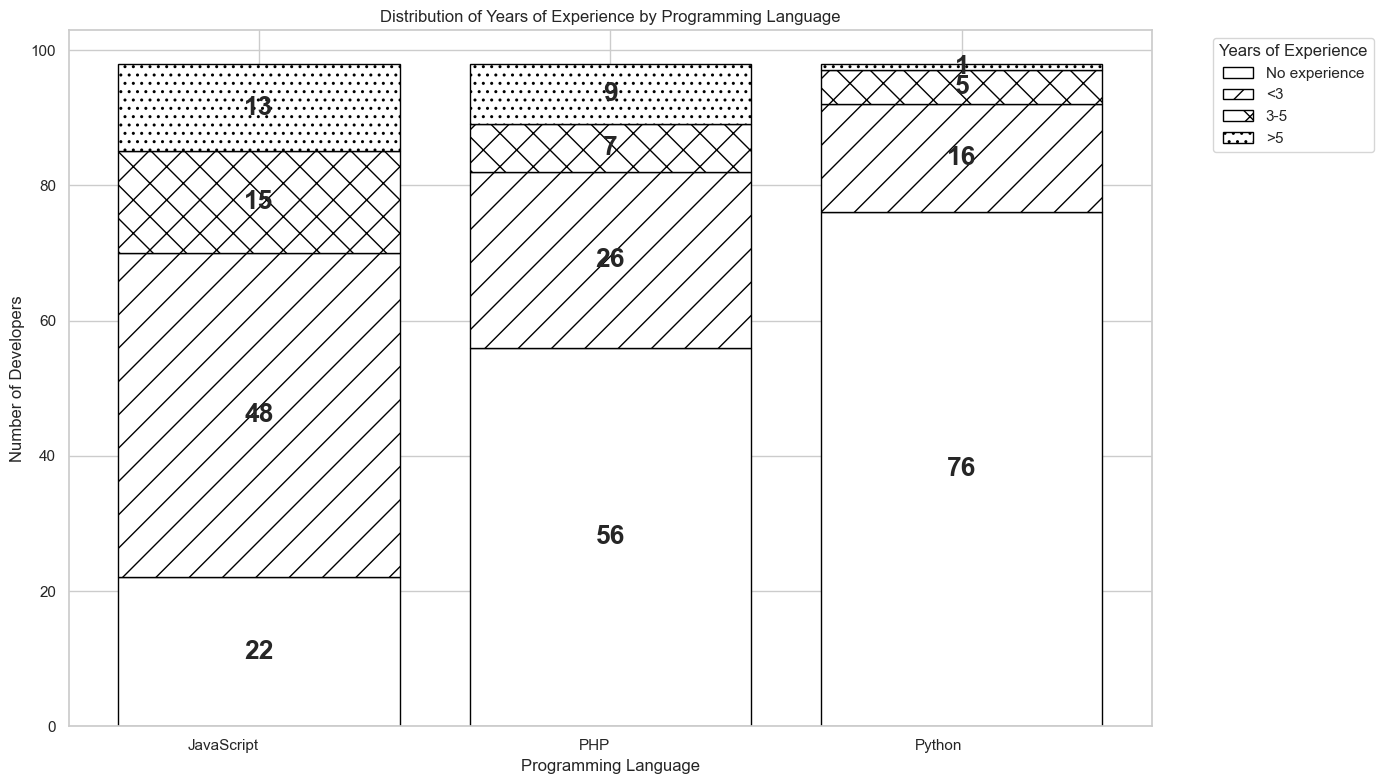

In [114]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

experience_levels = [NO_XP, UNDER_THREE_YEARS, THREE_TO_FIVE_YEARS, MORE_THAN_FIVE_YEARS]
experience_levels_without_no_xp = [UNDER_THREE_YEARS, THREE_TO_FIVE_YEARS, MORE_THAN_FIVE_YEARS]

# Prepare the data
experience_columns = [
    col for col in all_developer_metrics_workana_sonarqube.columns if col.endswith('_exp_ordinal')
]
experience_data = all_developer_metrics_workana_sonarqube[experience_columns]

# Count the occurrences of each experience level for each language
experience_counts = experience_data.apply(pd.value_counts).fillna(0)

# Create a mapping of full column names to language names
language_mapping = {col: col.replace('_exp_ordinal', '') for col in experience_columns}

# Rename the columns with just the language names
experience_counts.rename(columns=language_mapping, inplace=True)

# Remove languages with only NO_XP
languages_with_experience = experience_counts.loc[
    experience_counts.index != NO_XP
].sum() > 0
experience_counts = experience_counts.loc[:, languages_with_experience]

# Calculate the proportion of NO_XP for each language
no_xp_proportion = experience_counts.loc[NO_XP] / experience_counts.sum()

# Sort languages based on NO_XP proportion (ascending)
column_order = no_xp_proportion.sort_values().index

# Reindex the DataFrame to include all possible experience levels and sort them
experience_counts = experience_counts.reindex(experience_levels).fillna(0)

colors = ['#FFFFFF', '#FFFFFF' ,'#FFFFFF', '#FFFFFF']  # White, light gray, dark gray
patterns = ['', '/', 'x', '..']  # No pattern, diagonal lines, dots

# Create the stacked bar chart
fig, ax = plt.subplots(figsize=(14, 8))

bottom = np.zeros(len(column_order))

for idx, exp_level in enumerate(experience_levels):
    values = experience_counts.loc[exp_level, column_order]
    bars = ax.bar(
        column_order,
        values,
        bottom=bottom,
        color=colors[idx],
        edgecolor='black',
        linewidth=1,
        hatch=patterns[idx],
        label=exp_level,
    )
    bottom += values.values

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2.0,
                bar.get_y() + height / 2.0,
                f'{int(height)}',
                ha='center',
                va='center',
                fontsize=19,
                fontweight='bold',
            )

plt.title('Distribution of Years of Experience by Programming Language')
plt.xlabel('Programming Language')
plt.ylabel('Number of Developers')
plt.legend(title='Years of Experience', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.xticks(ha='right')
plt.show()

In [115]:
## Count Repos of the selected users
# Read the Excel file
repos_df = pd.read_excel('collected_repos_report.xlsx', sheet_name='Sheet1')

# Count unique repositories per user, only count the users that are available at all_developer_metrics_workana_sonarqube
repos_df = repos_df[repos_df['username'].isin(all_developer_metrics_workana_sonarqube['username'])]
repos_per_user = repos_df.groupby('username')['repository'].nunique()

# Get total number of unique repositories
total_repos = repos_df['repository'].nunique()

print(f"Total number of unique repositories analyzed: {total_repos}")
print("Total Sum: ", repos_per_user.sum())

Total number of unique repositories analyzed: 401
Total Sum:  405


In [116]:
# Create a table to summarize the data of all_developer_metrics_workana_sonarqube
# Group by programming language and experience level
languages = ['JavaScript', 'PHP', 'Python']
experience_levels = ['<3', '3-5', '>5']

summary_data = []

for lang in languages:
    for exp in experience_levels:
        # Filter data for this language and experience level
        mask = all_developer_metrics_workana_sonarqube[f'{lang}_exp_ordinal'] == exp
        filtered_df = all_developer_metrics_workana_sonarqube[mask]
        
        # Calculate metrics
        high_issues = filtered_df[f'{lang}_high_issues'].sum()
        medium_issues = filtered_df[f'{lang}_medium_issues'].sum()
        low_issues = filtered_df[f'{lang}_low_issues'].sum()
        maintainability = filtered_df[f'{lang}_maintainability_issues'].sum()
        reliability = filtered_df[f'{lang}_reliability_issues'].sum()
        total_issues = filtered_df[f'{lang}_total_issues'].sum()
        loc = filtered_df[f'{lang}_loc'].sum()
        dev_count = len(filtered_df)
        
        summary_data.append({
            'Language': lang,
            'Experience': exp,
            'High': int(high_issues) if not pd.isna(high_issues) else 0,
            'Medium': int(medium_issues) if not pd.isna(medium_issues) else 0,
            'Low': int(low_issues) if not pd.isna(low_issues) else 0,
            'Maintainability': int(maintainability) if not pd.isna(maintainability) else 0,
            'Reliability': int(reliability) if not pd.isna(reliability) else 0,
            'Total Issues': int(total_issues) if not pd.isna(total_issues) else 0,
            'LOC': int(loc) if not pd.isna(loc) else 0,
            'Developers': dev_count
        })

# Create DataFrame
summary_df = pd.DataFrame(summary_data)
summary_df


,Language,Experience,High,Medium,Low,Maintainability,Reliability,Total Issues,LOC,Developers
0,JavaScript,<3,4831,2515,1376,8122,1837,8722,225079,48
1,JavaScript,3-5,2855,1252,833,4718,1035,4940,99091,15
2,JavaScript,>5,179,284,128,550,211,591,24758,13
3,PHP,<3,504,473,1674,2471,221,2651,46267,26
4,PHP,3-5,375,586,1290,1817,449,2251,70923,7
5,PHP,>5,186,277,740,1042,182,1203,19266,9
6,Python,<3,324,214,184,701,27,722,20324,16
7,Python,3-5,48,177,194,418,6,419,6662,5
8,Python,>5,113,186,227,525,3,526,21830,1


### Experience Distribution Across All Programming Languages

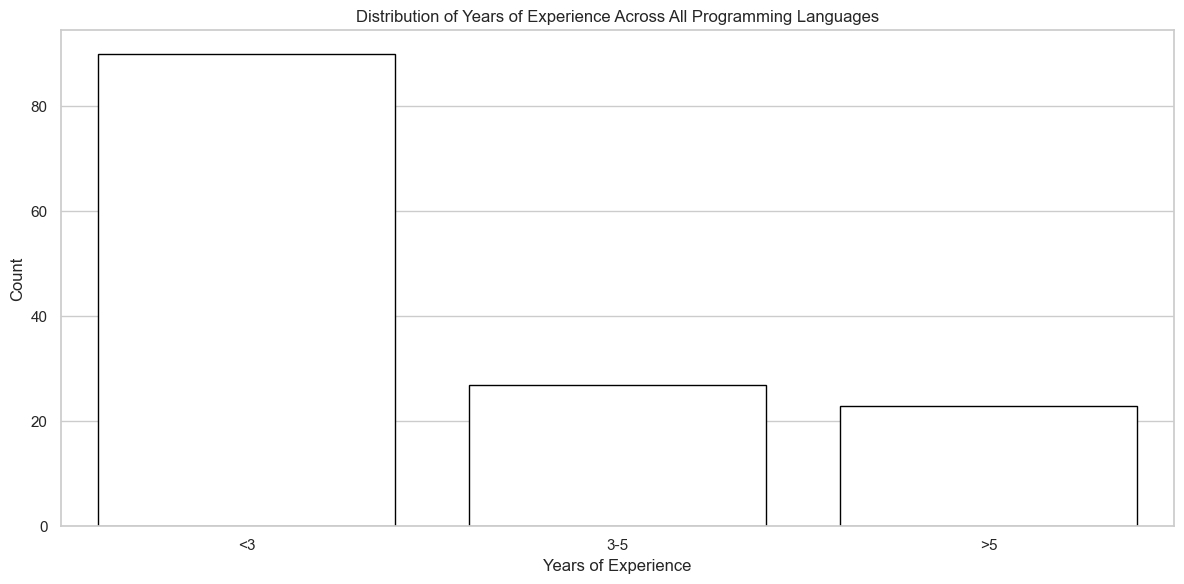

Most common experience level: No experience
Total number of experience entries: 294
<3: 90 (30.61%)
3-5: 27 (9.18%)
>5: 23 (7.82%)


In [117]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Prepare the data
experience_columns = [col for col in all_developer_metrics_workana_sonarqube.columns if col.endswith('_exp_ordinal')]
experience_data = all_developer_metrics_workana_sonarqube[experience_columns]

# Flatten the experience data
all_experience = experience_data.values.flatten()

# Remove 'NO_XP' entries
all_experience = all_experience[all_experience != 'NO_XP']

# Create the plot
plt.figure(figsize=(12, 6))
sns.countplot(x=all_experience, order=experience_levels_without_no_xp, color='#FFFFFF', edgecolor='black')

plt.title('Distribution of Years of Experience Across All Programming Languages')
plt.xlabel('Years of Experience')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Print some basic statistics
print("Most common experience level:", pd.Series(all_experience).mode().values[0])
print("Total number of experience entries:", len(all_experience))
for level in experience_levels_without_no_xp:
    count = (all_experience == level).sum()
    percentage = (count / len(all_experience)) * 100
    print(f"{level}: {count} ({percentage:.2f}%)")

### Issue Density by Experience Level

In [118]:
import numpy as np

MIN_LOC_THRESHOLD = 1000

def calculate_issue_density(severity):
    issue_density = dict()
    for developer in all_developer_metrics_workana_sonarqube['username'].unique():
        developer_statistics = all_developer_metrics_workana_sonarqube[all_developer_metrics_workana_sonarqube['username'] == developer]
        
        for lang in programming_languages:
            # check if developer has experience with the language
            if developer_statistics[lang+'_exp_ordinal'].iloc[0] != 'NO_XP':
                # Get the total issues for the language and calculate the average issue density
                total_issues = developer_statistics[lang + '_' + severity + '_issues'].iloc[0]
                total_loc = developer_statistics[lang+'_loc'].iloc[0]
                if total_loc >= MIN_LOC_THRESHOLD:
                    if lang not in issue_density:
                        issue_density[lang] = dict()

                    developer_experience = developer_statistics[lang+'_exp_ordinal'].iloc[0]

                    if developer_experience not in issue_density[lang]:
                        issue_density[lang][developer_experience] = []

                    developer_issue_density = total_issues / total_loc
                    issue_density[lang][developer_experience].append(developer_issue_density * 1000)

    # Remove outliers and calculate means
    all_issue_densities = {lang: {exp: densities for exp, densities in lang_data.items()} 
                          for lang, lang_data in issue_density.items()}
    
    outlier_removal = True
    if outlier_removal:
        for lang in all_issue_densities:
            for exp in all_issue_densities[lang]:
                values = all_issue_densities[lang][exp]
                if values:
                    q1 = np.percentile(values, 25)
                    q3 = np.percentile(values, 75)
                    iqr = q3 - q1
                    lower_bound = q1 - 1.5 * iqr
                    upper_bound = q3 + 1.5 * iqr
                    all_issue_densities[lang][exp] = [x for x in values if lower_bound <= x <= upper_bound]

    average_densities = {lang: {exp: np.mean(densities) if densities else 0 
                              for exp, densities in lang_data.items()}
                        for lang, lang_data in all_issue_densities.items()}

    return average_densities, all_issue_densities

average_issue_density_high, issue_density_high = calculate_issue_density('high')
average_issue_density_medium, issue_density_medium = calculate_issue_density('medium')
average_issue_density_low, issue_density_low = calculate_issue_density('low')

average_issue_density_reliability, issue_density_reliability = calculate_issue_density('reliability')
average_issue_density_maintainability, issue_density_maintainability = calculate_issue_density('maintainability')

average_issue_density_total, issue_density_total = calculate_issue_density('total')

issue_density_total


{'JavaScript': {'<3': [5.323505323505323,
   47.28950403690888,
   50.74292122231567,
   29.98236331569665,
   53.63098972953337,
   66.34232640424591,
   39.08794788273615,
   2.9806259314456036,
   73.69758576874206,
   104.06442682773373,
   36.265809517154636,
   1.518679761061051,
   63.36011822296111,
   43.438914027149316,
   35.71931802169931,
   94.75728155339806,
   93.80594343000358,
   102.83097418817653,
   69.45428773919205,
   28.70258006648024,
   13.003095975232197,
   18.606035798012876,
   10.64773735581189,
   136.7942402425161,
   15.083004973838898],
  '>5': [19.193175759729872,
   29.42231790455687,
   26.004728132387708,
   28.24228911185433,
   18.99335232668566],
  'No experience': [75.78532187632061,
   219.01007446342533,
   1.5840687938447613,
   33.77483443708609,
   60.23424428332404,
   128.135593220339,
   33.86960203217612],
  '3-5': [54.38147799165433,
   2.4801587301587302,
   91.85082872928177,
   54.950889301831694,
   10.35058430717863,
   59.3724

## Statistical Analysis

In [119]:
def plot_issue_density_by_experience_level_and_language(issue_density, average_issue_density, severity):
    import os
    import matplotlib.pyplot as plt
    import numpy as np
    from scipy import stats

    # Ensure the 'plots' directory exists
    os.makedirs('plots', exist_ok=True)

    # Set up the plot
    fig, ax = plt.subplots(figsize=(6, 3))
    
    # Width of each bar
    bar_width = 0.15
    
    # Position of bars on x-axis
    x = np.arange(len(experience_levels_without_no_xp))
    
    # Plot bars for each language
    averages_by_exp = []  # To store averages for regression line
    
    # Define colors for each language
    colors = ['#FFFFFF', '#D3D3D3', '#808080']  # White, light gray, dark gray
    for i, lang in enumerate(reversed(programming_languages)):
        densities = []
        for exp_level in experience_levels_without_no_xp:
            density = average_issue_density[lang].get(exp_level, 0)
            densities.append(density)
        
        # Plot bars with corresponding color
        bars = ax.bar(x + i*bar_width, densities, bar_width, 
                     color=colors[i], edgecolor='black', 
                     label=lang, alpha=1)  # Make bars slightly visible when value is 0
    
    # Add dummy scatter plot for legend
    ax.scatter([], [], marker='D', color='black', s=100, label='Average', zorder=3)
    
    # Calculate and plot averages for each experience level
    for i, exp_level in enumerate(experience_levels_without_no_xp):
        exp_densities = []
        for lang in programming_languages:
            density = average_issue_density[lang].get(exp_level, 0)
            if density > 0:
                exp_densities.append(density)
        
        if exp_densities:
            avg = np.mean(exp_densities)
            averages_by_exp.append(avg)
            # Plot diamond marker for average
            ax.scatter(i + bar_width, avg, 
                      marker='D', color='black', s=100, zorder=3)

    # Customize the plot
    print("\n")
    print("================================================")
    print(f'{severity} Issue Density by Years of Experience')
    ax.set_xlabel('Years of Experience')
    ax.set_ylabel('Issue Density (KLOC)')
    ax.set_xticks(x + bar_width)
    ax.set_xticklabels(experience_levels_without_no_xp)
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left')

    plt.tight_layout()
    
    # Save the plot
    filename = 'plots/' + f'Issue_Density_{severity}'.replace(' ', '_') + '.png'
    plt.savefig(filename, format='png', dpi=300, bbox_inches='tight')
    
    plt.show()

    # Print the averages
    print(f"\nAverages for {severity}:")
    for exp_level, avg in zip(experience_levels_without_no_xp, averages_by_exp):
        print(f"{exp_level}: {avg:.1f}")


    def kruskal_wallis_test(issue_density):
        print("Per programming language")

        # Perform Kruskal-Wallis tests
        for lang in issue_density:
            try:
                result = stats.kruskal(issue_density[lang][UNDER_THREE_YEARS], issue_density[lang][THREE_TO_FIVE_YEARS], issue_density[lang][MORE_THAN_FIVE_YEARS])
                print(f"{lang}: {result}")
            except Exception as e:
                print(f"{lang}: No data")
                print(issue_density[lang][UNDER_THREE_YEARS])
                print(issue_density[lang][THREE_TO_FIVE_YEARS])
                print(issue_density[lang][MORE_THAN_FIVE_YEARS])
                print(e)

        print("General analysis")
        all_densities = dict()
        all_densities[UNDER_THREE_YEARS] = []
        all_densities[THREE_TO_FIVE_YEARS] = []
        all_densities[MORE_THAN_FIVE_YEARS] = []
        
        for lang in issue_density:
            all_densities[UNDER_THREE_YEARS].extend(issue_density[lang][UNDER_THREE_YEARS])
            all_densities[THREE_TO_FIVE_YEARS].extend(issue_density[lang][THREE_TO_FIVE_YEARS])
            all_densities[MORE_THAN_FIVE_YEARS].extend(issue_density[lang][MORE_THAN_FIVE_YEARS])

        for exp in experience_levels_without_no_xp:
            if len(all_densities[exp]) < 5:
                print(f"Warning: Less than 5 datapoints under Kruskal Wallis Measurement for {exp}, only {len(all_densities[exp])} datapoints")

        result = stats.kruskal(all_densities[UNDER_THREE_YEARS], all_densities[THREE_TO_FIVE_YEARS], all_densities[MORE_THAN_FIVE_YEARS])
        print(f"Overall: {result}")

    kruskal_wallis_test(issue_density)



Total Issue Density by Years of Experience


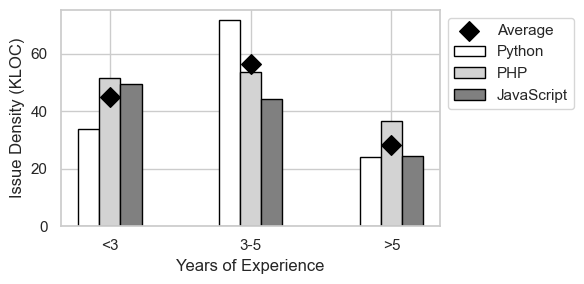


Averages for Total:
<3: 45.0
3-5: 56.6
>5: 28.4
Per programming language
JavaScript: KruskalResult(statistic=2.436338295850476, pvalue=0.29577118479838305)
PHP: KruskalResult(statistic=0.19544648943421644, pvalue=0.9068998583526665)
Python: KruskalResult(statistic=2.5, pvalue=0.2865047968601901)
General analysis
Overall: KruskalResult(statistic=3.7546976723020946, pvalue=0.15299518385591715)


High Issue Density by Years of Experience


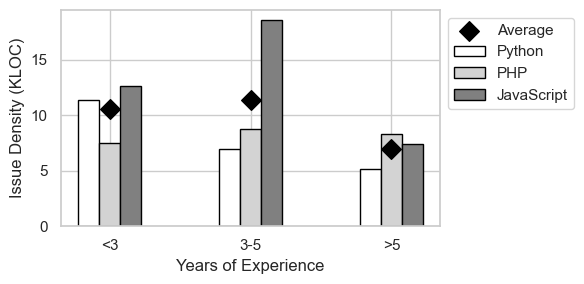


Averages for High:
<3: 10.5
3-5: 11.4
>5: 7.0
Per programming language
JavaScript: KruskalResult(statistic=1.822648902821313, pvalue=0.4019914531497466)
PHP: KruskalResult(statistic=0.42495106505468694, pvalue=0.8085800999909105)
Python: KruskalResult(statistic=1.0, pvalue=0.6065306597126334)
General analysis
Overall: KruskalResult(statistic=1.4347889633586084, pvalue=0.4880221515301879)


Medium Issue Density by Years of Experience


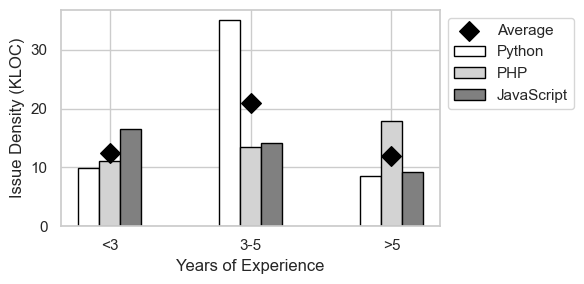


Averages for Medium:
<3: 12.5
3-5: 20.9
>5: 11.9
Per programming language
JavaScript: KruskalResult(statistic=0.7163710273466535, pvalue=0.6989433994211264)
PHP: KruskalResult(statistic=0.960673822301731, pvalue=0.6185749518963075)
Python: KruskalResult(statistic=2.1428571428571423, pvalue=0.34251885509304575)
General analysis
Overall: KruskalResult(statistic=0.11624588614275365, pvalue=0.9435339393452977)


Low Issue Density by Years of Experience


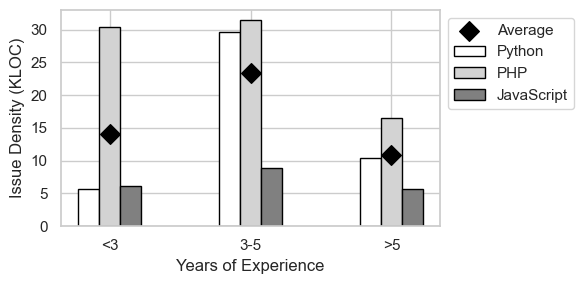


Averages for Low:
<3: 14.1
3-5: 23.4
>5: 10.8
Per programming language
JavaScript: KruskalResult(statistic=0.25183002575369073, pvalue=0.8816897758769335)
PHP: KruskalResult(statistic=0.9344785276073586, pvalue=0.6267301186396179)
Python: KruskalResult(statistic=3.200000000000003, pvalue=0.20189651799465513)
General analysis
Overall: KruskalResult(statistic=0.7878189965523508, pvalue=0.6744150892067549)


Reliability Issue Density by Years of Experience


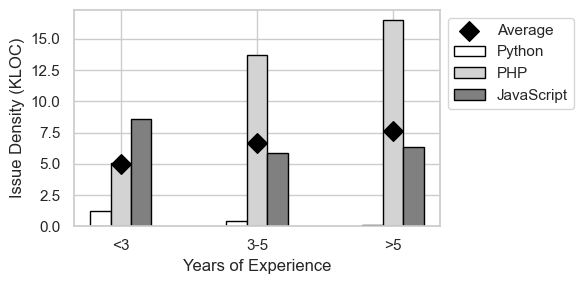


Averages for Reliability:
<3: 4.9
3-5: 6.7
>5: 7.6
Per programming language
JavaScript: KruskalResult(statistic=0.3313731369609337, pvalue=0.8473117667886658)
PHP: KruskalResult(statistic=1.0716652640437652, pvalue=0.585181846098508)
Python: KruskalResult(statistic=1.0, pvalue=0.6065306597126334)
General analysis
Overall: KruskalResult(statistic=0.0019258479115868688, pvalue=0.9990375395067073)


Maintainability Issue Density by Years of Experience


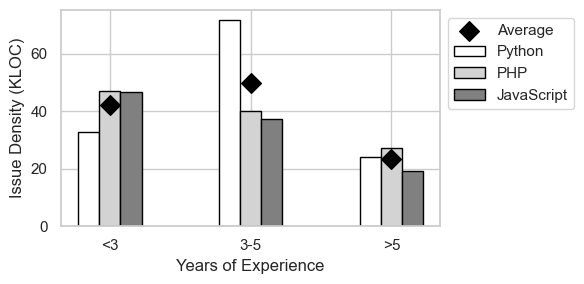


Averages for Maintainability:
<3: 42.2
3-5: 49.8
>5: 23.5
Per programming language
JavaScript: KruskalResult(statistic=3.4315447154471883, pvalue=0.17982477800709576)
PHP: KruskalResult(statistic=0.5985548738922927, pvalue=0.7413537019938123)
Python: KruskalResult(statistic=2.5, pvalue=0.2865047968601901)
General analysis
Overall: KruskalResult(statistic=4.994240886864816, pvalue=0.08232170766576219)


In [120]:
plot_issue_density_by_experience_level_and_language(issue_density_total,average_issue_density_total, 'Total')

plot_issue_density_by_experience_level_and_language(issue_density_high,average_issue_density_high, 'High')
plot_issue_density_by_experience_level_and_language(issue_density_medium,average_issue_density_medium, 'Medium')
plot_issue_density_by_experience_level_and_language(issue_density_low,average_issue_density_low, 'Low')

plot_issue_density_by_experience_level_and_language(issue_density_reliability,average_issue_density_reliability, 'Reliability')
plot_issue_density_by_experience_level_and_language(issue_density_maintainability,average_issue_density_maintainability, 'Maintainability')

In [121]:
def plot_issue_density_by_experience_level(average_issue_density, severity):
    import os
    import matplotlib.pyplot as plt
    import numpy as np

    # Ensure the 'plots' directory exists
    os.makedirs('plots', exist_ok=True)

    # Prepare the data
    average_densities = []

    for level in experience_levels_without_no_xp:
        densities = [lang_data.get(level, 0) for lang_data in average_issue_density.values()]
        # Exclude zero values
        non_zero_densities = [d for d in densities if d != 0]
        if non_zero_densities:
            average_density = np.mean(non_zero_densities)
        else:
            average_density = 0
        average_densities.append(average_density)

    # Create grayscale colors for the bars
    grayscale_colors = ['#FFFFFF', '#FFFFFF', '#FFFFFF']  # Light to dark gray

    # Create the plot
    plt.figure(figsize=(10, 6))
    bars = plt.bar(experience_levels_without_no_xp, average_densities, color=grayscale_colors, edgecolor='black')
    plt.title('Average Issue Density for ' + severity + ' by Years of Experience')
    plt.xlabel('Years of Experience')
    plt.ylabel('Average Issue Density (per 1000 LOC)')
    plt.ylim(0, max(average_densities) * 1.1)  # Set y-axis limit to 110% of max value

    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.3f}', ha='center', va='bottom')

    plt.tight_layout()

    # Save the plot to the 'plots' directory with the same title
    # Sanitize the title to create a valid filename
    filename = 'plots/' + plt.gca().get_title().replace(' ', '_').replace(':', '').replace('/', '_') + '.png'
    plt.savefig(filename, format='png', dpi=300, bbox_inches='tight')

    plt.show()

    # Print the average densities
    for level, density in zip(experience_levels_without_no_xp, average_densities):
        print(f"{level}: {density:.3f}")

### Asessing the correlation of issue densities between different programming languages of the same developer

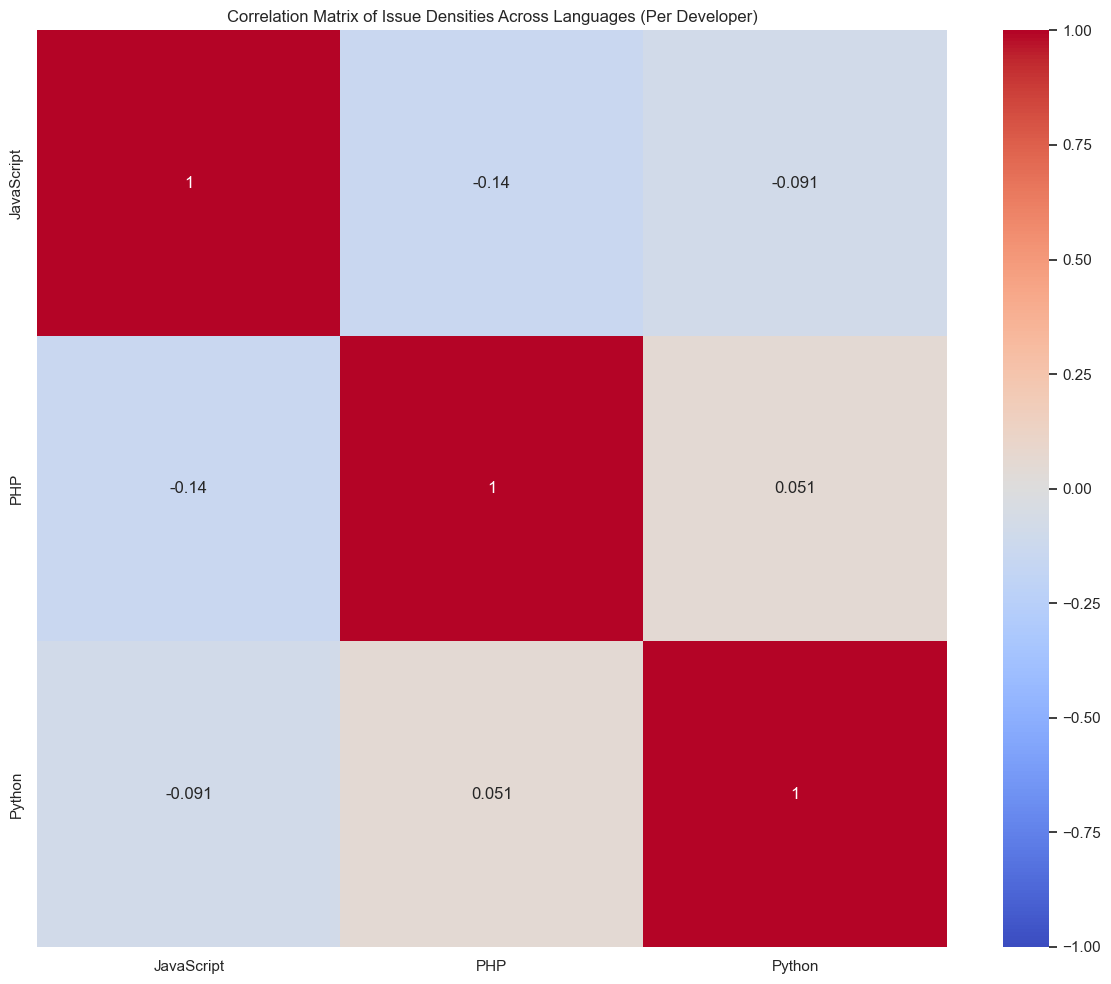

Correlation Matrix of Issue Densities Across Languages (Per Developer):
            JavaScript       PHP    Python
JavaScript    1.000000 -0.142312 -0.091409
PHP          -0.142312  1.000000  0.051373
Python       -0.091409  0.051373  1.000000


In [122]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Create a dictionary to store issue densities for each developer and language
developer_data = {}

# Collect issue densities for each developer and language
for developer in all_developer_metrics_workana_sonarqube['username'].unique():
    developer_data[developer] = {}
    developer_statistics = all_developer_metrics_workana_sonarqube[all_developer_metrics_workana_sonarqube['username'] == developer]
    
    for lang in programming_languages:
        if developer_statistics[lang+'_exp_ordinal'].iloc[0] != 'NO_XP':
            total_issues = developer_statistics[lang + '_total_issues'].iloc[0]
            total_loc = developer_statistics[lang+'_loc'].iloc[0]
            if total_loc > 0:
                issue_density = (total_issues / total_loc) * 1000
                developer_data[developer][lang] = issue_density

# Create a DataFrame with aligned values for each developer
df_data = pd.DataFrame(developer_data).T

# Drop any columns (languages) with all NaN values
df_data.dropna(axis=1, how='all', inplace=True)

# Calculate the correlation matrix
correlation_matrix = df_data.corr()

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title("Correlation Matrix of Issue Densities Across Languages (Per Developer)")
plt.tight_layout()
plt.show()

print("Correlation Matrix of Issue Densities Across Languages (Per Developer):")
print(correlation_matrix)

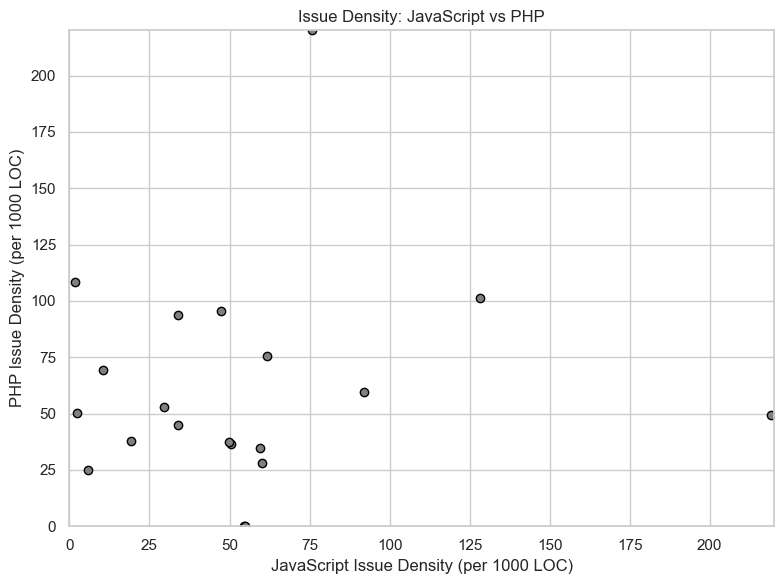

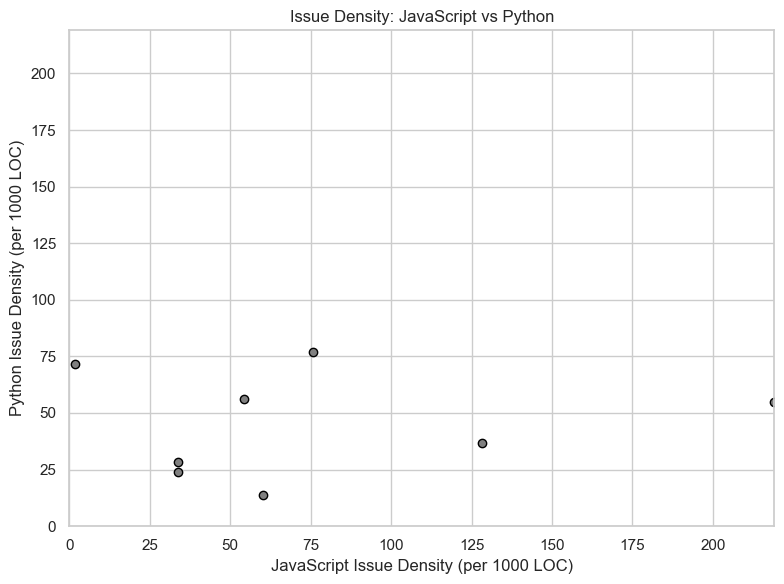

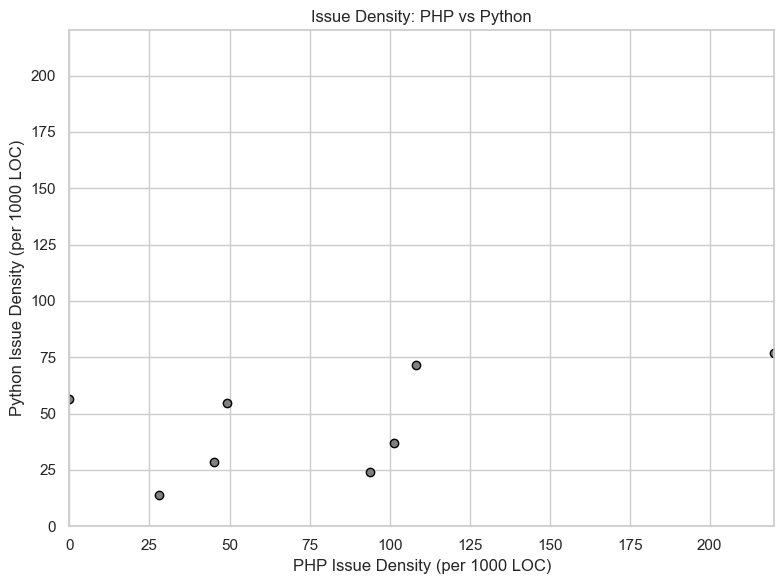

In [123]:
import matplotlib.pyplot as plt
import numpy as np

for i, lang1 in enumerate(programming_languages):
    for lang2 in programming_languages[i+1:]:
        # Get data for each language from issue_density_total
        lang1_data = []
        lang2_data = []
        
        # Create sets of developers with data for both languages
        developers_lang1 = set()
        developers_lang2 = set()
        
        # Collect developers for each language
        for exp_level in issue_density_total[lang1]:
            lang1_data.extend(issue_density_total[lang1][exp_level])
            developers_lang1.add(exp_level)
        for exp_level in issue_density_total[lang2]:
            lang2_data.extend(issue_density_total[lang2][exp_level])
            developers_lang2.add(exp_level)
            
        # Find common developers
        common_developers = developers_lang1.intersection(developers_lang2)
        
        # Only plot if we have data for both languages
        if len(common_developers) > 0:
            # Get data only for common developers
            filtered_lang1_data = []
            filtered_lang2_data = []
            
            for dev in common_developers:
                if dev in issue_density_total[lang1] and dev in issue_density_total[lang2]:
                    filtered_lang1_data.extend(issue_density_total[lang1][dev])
                    filtered_lang2_data.extend(issue_density_total[lang2][dev])
            
            # Make sure arrays are same length by taking minimum
            min_len = min(len(filtered_lang1_data), len(filtered_lang2_data))
            filtered_lang1_data = filtered_lang1_data[:min_len]
            filtered_lang2_data = filtered_lang2_data[:min_len]
            
            plt.figure(figsize=(8, 6))
            plt.scatter(filtered_lang1_data, filtered_lang2_data, color='gray', edgecolor='black')
            plt.title(f'Issue Density: {lang1} vs {lang2}')
            plt.xlabel(f'{lang1} Issue Density (per 1000 LOC)')
            plt.ylabel(f'{lang2} Issue Density (per 1000 LOC)')
            
            # Set the same max value for both axes
            max_value = max(max(filtered_lang1_data), max(filtered_lang2_data))
            plt.xlim(0, max_value)
            plt.ylim(0, max_value)
            
            plt.grid(True)
            plt.tight_layout()
            plt.show()